In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import seaborn as sns
import itertools
from scipy.linalg import block_diag
import time
import os
import pickle
from scipy.misc import comb
from functools import partial
from itertools import combinations

In [2]:
from __future__ import print_function

import sys

import cplex
from cplex.exceptions import CplexError

In [3]:
sushi_score = np.loadtxt('./sushi3-2016/sushi3b.5000.10.score')

In [3]:
print(sushi_score[0])
print(np.where(sushi_score[0]!=-1))

NameError: name 'sushi_score' is not defined

In [64]:
sushi_order = np.loadtxt('./sushi3-2016/sushi3b.5000.10.order', skiprows=1)
flips = []
for s in range(len(sushi_order)):
    rating = sorted(zip(np.take(sushi_score[s], np.where(sushi_score[s]!=-1)[0]), np.where(sushi_score[s]!=-1)[0]), reverse=True)
    ranking = sushi_order[s][2:]
    flips.append(countflips(ranking,rating))

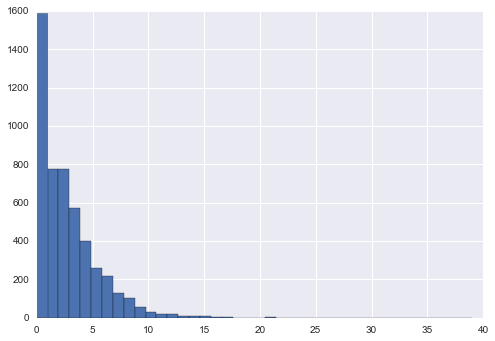

In [68]:
plt.hist(flips, bins=40)
plt.show()

In [100]:
unique, counts = np.unique(flips, return_counts=True)
print(np.array(counts).astype(float)/np.sum(counts))
print(unique)
distribution = (np.cumsum(np.array(counts).astype(float)/np.sum(counts)))
print(distribution)
with open('./dist.p','wb') as file_:
    pickle.dump(distribution, file_)
with open('./error_nums.p', 'wb') as file_:
    pickle.dump(unique, file_)

[  3.17200000e-01   1.55400000e-01   1.54800000e-01   1.14600000e-01
   7.96000000e-02   5.24000000e-02   4.34000000e-02   2.58000000e-02
   2.08000000e-02   1.16000000e-02   6.00000000e-03   3.80000000e-03
   4.40000000e-03   2.20000000e-03   1.60000000e-03   2.20000000e-03
   1.20000000e-03   4.00000000e-04   2.00000000e-04   4.00000000e-04
   2.00000000e-04   2.00000000e-04   2.00000000e-04   2.00000000e-04
   2.00000000e-04   2.00000000e-04   2.00000000e-04   2.00000000e-04
   2.00000000e-04   2.00000000e-04]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 27 28
 30 31 32 33 39]
[ 0.3172  0.4726  0.6274  0.742   0.8216  0.874   0.9174  0.9432  0.964
  0.9756  0.9816  0.9854  0.9898  0.992   0.9936  0.9958  0.997   0.9974
  0.9976  0.998   0.9982  0.9984  0.9986  0.9988  0.999   0.9992  0.9994
  0.9996  0.9998  1.    ]


In [58]:
print(rating)
print(ranking)

[(4.0, 58), (4.0, 3), (2.0, 87), (2.0, 60), (2.0, 4), (1.0, 44), (1.0, 12), (0.0, 74), (0.0, 67), (0.0, 1)]
[ 58.   4.   3.  44.  87.  60.  67.   1.  12.  74.]


In [10]:
sushi_order_small = np.loadtxt('./sushi3-2016/sushi3a.5000.10.order', skiprows=1)
print(len(sushi_order_small))

5000


In [5]:
def generate_correct_profiles(num_voters, num_profiles):
    profiles = []
    for i in range(num_profiles):
        profiles.append(np.array([list(x[2:]) for x in sushi_order_small[np.random.choice(5000,num_voters)] +1]))
    return profiles

In [6]:
def induce_errors(profiles):
    error_profiles = np.copy(profiles)
    with open('./dist.p','rb') as file_:
        distribution = pickle.load(file_)
    with open('./error_nums.p', 'rb') as file_:
        error_nums = pickle.load(file_)
    for i in range(len(error_profiles)):
        for j in range(len(error_profiles[i])):
#             print(profiles[i][j])
            draw = np.random.uniform(0,1)
            errors = error_nums[np.min(np.where(distribution>draw)[0])]
            indices = np.random.choice(range(9),errors)
            for k in indices:
                tmp = error_profiles[i][j][k]
                error_profiles[i][j][k] = error_profiles[i][j][k+1]
                error_profiles[i][j][k+1] = tmp
#             print (profiles[i][j])
    return error_profiles

In [7]:
def simulate_voting(profile, size_subset):
    num_voters = 20
    
    n,m = len(profile), len(profile[0])
    k=size_subset

    def Ind(m,k,i,r):
        return (i-1)*(m-k+1)+r+m
    IndY = partial(Ind,m,k)
    # IndY(1,1)

    nIneq  = int(n*((m-k+2)*(m-k+3)/2-1)+comb(m,k))
    nEq = 1
    nVar = int(m+n*(m-k+1)+1)
    Aineq = np.zeros((nIneq, nVar))
    bineq = np.zeros((nIneq, 1))
    Aeq = np.zeros((nEq, nVar))
    beq = np.zeros((nEq, 1))
    f = np.zeros((nVar, 1))
    ctype = 'B'*(nVar-1)+'C'
    f[-1] = 1
    Aeq[0][0:m] = 1
    beq = k
    countIneq = 1

    for i in range(1,n+1):
        for r in range(1,m-k+2):
            for j in range(1,r+1):
                Aineq[countIneq-1, IndY(i,r)-1] = 1
                Aineq[countIneq-1, profile[i-1,j-1]-1] = 1
                bineq[countIneq-1] = 1
                countIneq = countIneq + 1
            Aineq[countIneq-1, IndY(i,r)-1] = -1
            for j in range(1,r+1):
                Aineq[countIneq-1, profile[i-1,j-1]-1] = -1
            bineq[countIneq-1] = -1
            countIneq = countIneq + 1
    list_T = np.array([list(int(y)+1 for y in x) for x in list(combinations(range(m),k))])
    for indT in range(1, list_T.shape[0]+1):
        T = list_T[indT-1]
        first_indices_T = np.array([[i for i,elem in enumerate(x) if x[i] in T][0] + 1 for x in profile])
        Aineq[countIneq-1, nVar-1] = -1
        for i in range(1,n+1):
            Aineq[countIneq-1,IndY(i,first_indices_T[i-1])-1] = 1./first_indices_T[i-1]
        countIneq = countIneq + 1

    # data common to all populateby functions
    my_obj = list(i[0] for i in f)
    my_ub = [cplex.infinity]*len(f)
    my_lb = [0.0]*len(f)
    my_ctype = ctype
    my_colnames = ['x{}'.format(i) for i in range(len(f))]
    my_rhs = list(i[0] for i in bineq) + [float(beq)]
    my_rownames = ['r{}'.format(i) for i in range(nIneq+nEq)]
    my_sense = 'L'*nIneq+'E'*nEq

    def populatebynonzero(prob):
        prob.objective.set_sense(prob.objective.sense.minimize)

        prob.linear_constraints.add(rhs=my_rhs, senses=my_sense,
                                    names=my_rownames)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype,
                           names=my_colnames)

        rows, cols = np.nonzero(np.concatenate((Aineq,Aeq)))
        rows=list(rows)
        cols=list(cols)
        vals = [np.concatenate((Aineq,Aeq))[rows[i],cols[i]] for i in range(len(rows))]

        prob.linear_constraints.set_coefficients(zip(rows, cols, vals))


    def mipex1(pop_method):

        try:
            my_prob = cplex.Cplex()

            handle = populatebynonzero(my_prob)

            my_prob.solve()
        except CplexError as exc:
            print(exc)
            return

#         print()
#         # solution.get_status() returns an integer code
#         print("Solution status = ", my_prob.solution.get_status(), ":", end=' ')
#         # the following line prints the corresponding string
#         print(my_prob.solution.status[my_prob.solution.get_status()])
#         print("Solution value  = ", my_prob.solution.get_objective_value())

        numcols = my_prob.variables.get_num()
        numrows = my_prob.linear_constraints.get_num()

        slack = my_prob.solution.get_linear_slacks()
        x = my_prob.solution.get_values()

    #     for j in range(numrows):
    #         print("Row %d:  Slack = %10f" % (j, slack[j]))
        for j in range(m):
            print("Column %d:  Value = %10f" % (j, x[j]))
        print ("Column %d:  Value = %10f" % (numcols-1, x[numcols-1]))
        return x[:10]

    choices = mipex1('n')
    print (list((np.array(np.where(np.array(choices)>0.0))+1)[0]))
    selected_points = list((np.array(np.where(np.array(choices)>0.5))+1)[0])
    return selected_points

In [8]:
def countflips(ranking, rating):
    counter = 0
    i=0
    while i<len(ranking):
        if ranking[i]==rating[i][1]:
            i+=1
        else:
            j = np.where([x[1] for x in rating]==ranking[i])[0][0]
#             print(j)
            for k in range(j,i,-1):
                tmp = rating[k-1]
                rating[k-1] = rating[k]
                rating[k] = tmp
                if rating[k][0]!=rating[k-1][0]:
                    counter+=1
#                     print("adding 1")
#                 print (ranking[k],ranking[k-1])
#                 print (rating[k],rating[k-1])
#             print (rating)
#             print (ranking)
#             print (counter)
            i+=1
    return counter

In [63]:
#number of voters
n=100
#number of items in subset
k=9
profiles = generate_correct_profiles(30,50)
other_profiles = induce_errors(profiles)
correct_subsets = []
error_subsets = []
for i in range(len(profiles)):
    correct_subsets.append(simulate_voting(profiles[i],k))
    error_subsets.append(simulate_voting(other_profiles[i],k))

CPXPARAM_Read_DataCheck                          1
CPXPARAM_Read_APIEncoding                        "UTF-8"
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.02 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.02 ticks)
Column 0:  Value =   1.000000
Column 1:  Value =   1.000000
Column 2:  Value =   1.000000
Column 3:  Value =   1.000000
Column 4:  Value =   1.000000
Column 5:  Value =   1.000000
Column 6:  Value =   1.000000
Column 7:  Value =   1.000000
Column 8:  Value =   1.000000
Column 9:  Value =   0.000000
Column 70:  Value =   0.000000


/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[1, 2, 3, 4, 5, 6, 7, 8, 9]
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Read_APIEncoding                        "UTF-8"
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.02 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.02 ticks)
Column 0:  Value =   1.000000
Column 1:  Value =   1.000000
Column 2:  Value =   1.000000
Column 3:  Value =   1.000000
Column 4:  Value =   1.000000
Column 5:  Value =   1.000000
Column 6:  Value =   1.000000
Column 7:  Value =   1.000000
Column 8:  Value =   1.000000
Column 9:  Value =   0.000000
Column 70:  Value =   0.000000
[1, 2, 3, 4, 5, 6, 7, 8, 9]
CPXPARAM_Read_DataCheck                          1
CPXPAR

Tried aggregator 2 times.
MIP Presolve eliminated 60 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 71 rows, 41 columns, and 260 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.52 ticks)
Found incumbent of value 12.000000 after 0.01 sec. (0.58 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.23 ticks)
Cover probing fixed 0 vars, tightened 2 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 69 rows and 33 columns.
MIP Presolve added 2 rows and 2 columns.
MIP Presolve modified 19 coefficients.
Reduced MIP has 4 rows, 10 columns, and 19 nonzeros.
Reduced MIP has 6 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.12 ticks)
Probing fixed 0 vars, tightened 2 bounds.
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 2 rows and 2 columns.
MIP Presolve added 2 rows and 2 columns

Tried aggregator 2 times.
MIP Presolve eliminated 60 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 71 rows, 41 columns, and 251 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.52 ticks)
Found incumbent of value 13.000000 after 0.01 sec. (0.58 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.21 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 71 rows and 37 columns.
MIP Presolve added 2 rows and 2 columns.
Reduced MIP has 2 rows, 6 columns, and 8 nonzeros.
Reduced MIP has 3 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.09 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 6 columns, and 8 nonzeros.
Reduced MIP has 3 binaries, 3 genera

Tried aggregator 2 times.
MIP Presolve eliminated 60 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 71 rows, 41 columns, and 251 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.49 ticks)
Found incumbent of value 3.000000 after 0.01 sec. (0.56 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.22 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 70 rows and 34 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 4 binaries, 4 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.09 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 4 binaries, 4 gener

Tried aggregator 2 times.
MIP Presolve eliminated 61 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 70 rows, 41 columns, and 233 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.50 ticks)
Found incumbent of value 5.000000 after 0.01 sec. (0.56 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.18 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 69 rows and 34 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 5 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.08 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 5 binaries, 3 gener

Tried aggregator 2 times.
MIP Presolve eliminated 60 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 71 rows, 41 columns, and 251 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.52 ticks)
Found incumbent of value 2.000000 after 0.01 sec. (0.58 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.21 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 70 rows and 35 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 7 columns, and 9 nonzeros.
Reduced MIP has 5 binaries, 2 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.09 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 7 columns, and 9 nonzeros.
Reduced MIP has 5 binaries, 2 general

Tried aggregator 2 times.
MIP Presolve eliminated 60 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 71 rows, 41 columns, and 260 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.52 ticks)
Found incumbent of value 15.000000 after 0.01 sec. (0.58 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.23 ticks)
Cover probing fixed 0 vars, tightened 2 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 69 rows and 35 columns.
MIP Presolve added 1 rows and 1 columns.
MIP Presolve modified 19 coefficients.
Reduced MIP has 3 rows, 7 columns, and 12 nonzeros.
Reduced MIP has 4 binaries, 2 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.11 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.

Tried aggregator 2 times.
MIP Presolve eliminated 60 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 71 rows, 41 columns, and 251 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.52 ticks)
Found incumbent of value 14.000000 after 0.01 sec. (0.58 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.21 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 70 rows and 34 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 6 binaries, 2 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.09 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 6 binaries, 2 gene

Tried aggregator 4 times.
MIP Presolve eliminated 113 rows and 27 columns.
MIP Presolve modified 8 coefficients.
Aggregator did 35 substitutions.
Reduced MIP has 13 rows, 9 columns, and 41 nonzeros.
Reduced MIP has 8 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.62 ticks)
Found incumbent of value 0.000000 after 0.01 sec. (0.66 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.66 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.66 ticks)
Column 0:  Value =   1.000000
Column 1:  Value =   1.000000
Column 2:  Value =   1.000000
Column 3:  Value =   1.000000
Column 4:  Value =   1.000000
Column 5:  Value =   1.000000
Column 6:  Value =   0.000000
Column 7:  Value =   1.000000
Column 8:  Value =   1.000000
Column 9:  Value =   1.000000

Tried aggregator 6 times.
MIP Presolve eliminated 124 rows and 34 columns.
Aggregator did 37 substitutions.
All rows and columns eliminated.
Presolve time = 0.01 sec. (0.69 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.72 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.72 ticks)
Column 0:  Value =   1.000000
Column 1:  Value =   1.000000
Column 2:  Value =   1.000000
Column 3:  Value =   1.000000
Column 4:  Value =   1.000000
Column 5:  Value =   1.000000
Column 6:  Value =   0.000000
Column 7:  Value =   1.000000
Column 8:  Value =   1.000000
Column 9:  Value =   1.000000
Column 70:  Value =   0.000000
[1, 2, 3, 4, 5, 6, 8, 9, 10]
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Read_APIEncoding                        "UTF-8"
CPXPARAM_MIP_Strat

Tried aggregator 2 times.
MIP Presolve eliminated 98 rows and 19 columns.
MIP Presolve modified 25 coefficients.
Aggregator did 31 substitutions.
Reduced MIP has 32 rows, 21 columns, and 118 nonzeros.
Reduced MIP has 19 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.58 ticks)
Found incumbent of value 0.000000 after 0.01 sec. (0.62 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.62 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.62 ticks)
Column 0:  Value =   1.000000
Column 1:  Value =   1.000000
Column 2:  Value =   1.000000
Column 3:  Value =   1.000000
Column 4:  Value =   1.000000
Column 5:  Value =   1.000000
Column 6:  Value =   1.000000
Column 7:  Value =   1.000000
Column 8:  Value =   0.000000
Column 9:  Value =   1.000

Tried aggregator 2 times.
MIP Presolve eliminated 64 rows and 2 columns.
MIP Presolve modified 59 coefficients.
Aggregator did 31 substitutions.
Reduced MIP has 66 rows, 38 columns, and 196 nonzeros.
Reduced MIP has 36 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.55 ticks)
Found incumbent of value 0.000000 after 0.01 sec. (0.61 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.61 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.61 ticks)
Column 0:  Value =   0.000000
Column 1:  Value =   1.000000
Column 2:  Value =   1.000000
Column 3:  Value =   1.000000
Column 4:  Value =   1.000000
Column 5:  Value =   1.000000
Column 6:  Value =   1.000000
Column 7:  Value =   1.000000
Column 8:  Value =   1.000000
Column 9:  Value =   1.0000

Tried aggregator 2 times.
MIP Presolve eliminated 61 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 70 rows, 41 columns, and 233 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.50 ticks)
Found incumbent of value 4.000000 after 0.02 sec. (0.56 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.01 sec. (0.19 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 69 rows and 34 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 5 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.08 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 2 rows, 8 columns, and 10 nonzeros.
Reduced MIP has 5 binaries, 3 gener

Tried aggregator 2 times.
MIP Presolve eliminated 60 rows and 0 columns.
MIP Presolve modified 60 coefficients.
Aggregator did 30 substitutions.
Reduced MIP has 71 rows, 41 columns, and 260 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.50 ticks)
Found incumbent of value 5.000000 after 0.01 sec. (0.57 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.23 ticks)
Cover probing fixed 0 vars, tightened 3 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 69 rows and 34 columns.
MIP Presolve added 1 rows and 1 columns.
MIP Presolve modified 18 coefficients.
Reduced MIP has 3 rows, 8 columns, and 14 nonzeros.
Reduced MIP has 3 binaries, 4 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.11 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.


Tried aggregator 2 times.
MIP Presolve eliminated 88 rows and 14 columns.
MIP Presolve modified 35 coefficients.
Aggregator did 31 substitutions.
Reduced MIP has 42 rows, 26 columns, and 136 nonzeros.
Reduced MIP has 24 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.55 ticks)
Found incumbent of value 0.000000 after 0.01 sec. (0.60 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.60 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.60 ticks)
Column 0:  Value =   1.000000
Column 1:  Value =   1.000000
Column 2:  Value =   0.000000
Column 3:  Value =   1.000000
Column 4:  Value =   1.000000
Column 5:  Value =   1.000000
Column 6:  Value =   1.000000
Column 7:  Value =   1.000000
Column 8:  Value =   1.000000
Column 9:  Value =   1.000

In [137]:
correct_subsets

[[2, 5, 8],
 [2, 4, 8],
 [2, 6, 8],
 [2, 5, 8],
 [5, 6, 8],
 [4, 5, 6],
 [2, 3, 5],
 [2, 7, 8],
 [1, 3, 8],
 [3, 5, 8]]

In [138]:
error_subsets

[[1, 3, 8],
 [2, 4, 8],
 [2, 6, 8],
 [5, 6, 8],
 [5, 6, 8],
 [3, 5, 6],
 [1, 2, 5],
 [2, 3, 8],
 [1, 3, 8],
 [3, 5, 8]]

In [139]:
profiles[0]

array([[  8.,   5.,   2.,   1.,   6.,   9.,   3.,   4.,   7.,  10.],
       [  8.,   9.,   3.,   4.,   1.,  10.,   2.,   7.,   6.,   5.],
       [  8.,   6.,   5.,   1.,   3.,   2.,   7.,   9.,  10.,   4.],
       [  1.,   8.,   3.,   6.,   2.,   9.,   4.,   7.,  10.,   5.],
       [  8.,   2.,   1.,   3.,   6.,   5.,   9.,   7.,  10.,   4.],
       [  8.,   7.,   9.,   4.,   3.,   2.,  10.,   1.,   6.,   5.],
       [  2.,   1.,   4.,   6.,   3.,   8.,   9.,  10.,   7.,   5.],
       [  8.,   5.,   3.,   6.,   1.,   9.,   2.,   4.,   7.,  10.],
       [  5.,   8.,   3.,   1.,   6.,   4.,   9.,   7.,  10.,   2.],
       [  5.,   8.,   1.,   7.,   6.,   9.,   3.,   2.,   4.,  10.]])

In [140]:
other_profiles[0]

array([[  8.,   5.,   2.,   6.,   1.,   9.,   3.,   4.,   7.,  10.],
       [  8.,   3.,   9.,   4.,   1.,  10.,   7.,   2.,   6.,   5.],
       [  8.,   6.,   5.,   1.,   3.,   2.,   7.,   9.,  10.,   4.],
       [  1.,   8.,   3.,   6.,   2.,   9.,   4.,   7.,  10.,   5.],
       [  8.,   2.,   6.,   1.,   3.,  10.,   5.,   9.,   7.,   4.],
       [  8.,   7.,   9.,   4.,   3.,   2.,  10.,   1.,   6.,   5.],
       [  1.,   2.,   6.,   4.,   3.,   8.,   9.,  10.,   7.,   5.],
       [  8.,   5.,   3.,   6.,   1.,   9.,   2.,   4.,   7.,  10.],
       [  3.,   8.,   5.,   1.,   6.,   4.,   2.,   7.,   9.,  10.],
       [  5.,   1.,   8.,   7.,   6.,   3.,   2.,   9.,   4.,  10.]])

In [154]:
print([list(x[:3]) for x in profiles[0]])
vals, cnts = np.unique([list(x[:3]) for x in profiles[0]], return_counts=True)
print (vals, cnts)
print (sorted(zip(cnts,vals), reverse=True))
[z[1] for z in sorted(zip(cnts,vals), reverse=True)[:3]]

[[8.0, 5.0, 2.0], [8.0, 9.0, 3.0], [8.0, 6.0, 5.0], [1.0, 8.0, 3.0], [8.0, 2.0, 1.0], [8.0, 7.0, 9.0], [2.0, 1.0, 4.0], [8.0, 5.0, 3.0], [5.0, 8.0, 3.0], [5.0, 8.0, 1.0]]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9.] [4 3 4 1 5 1 1 9 2]
[(9, 8.0), (5, 5.0), (4, 3.0), (4, 1.0), (3, 2.0), (2, 9.0), (1, 7.0), (1, 6.0), (1, 4.0)]


[8.0, 5.0, 3.0]

In [64]:
correct_subsets_plurality = []
error_subsets_plurality = []
for i in range(len(profiles)):
    vals, cnts = np.unique([list(x[:k]) for x in profiles[i]], return_counts=True)
    correct_subsets_plurality.append([int(z[1]) for z in sorted(zip(cnts,vals), reverse=True)[:k]])
    vals, cnts = np.unique([list(x[:k]) for x in other_profiles[i]], return_counts=True)
    error_subsets_plurality.append([int(z[1]) for z in sorted(zip(cnts,vals), reverse=True)[:k]])

In [60]:
for i in range(10):
    print(correct_subsets_plurality[i], correct_subsets[i])

[1, 8, 3, 9, 6, 4, 2, 5] [1, 2, 3, 4, 5, 6, 8, 9]
[8, 1, 6, 3, 9, 4, 7, 5] [1, 2, 3, 4, 5, 8, 9, 10]
[1, 8, 3, 9, 4, 2, 6, 7] [1, 2, 3, 4, 5, 6, 8, 9]
[8, 6, 9, 1, 3, 2, 7, 4] [1, 2, 3, 4, 5, 6, 8, 9]
[1, 8, 6, 5, 3, 9, 2, 4] [1, 2, 3, 4, 5, 6, 7, 8]
[3, 9, 8, 1, 4, 2, 6, 7] [1, 2, 3, 4, 5, 6, 7, 8]
[3, 9, 8, 1, 2, 6, 5, 4] [1, 2, 3, 5, 6, 8, 9, 10]
[8, 3, 4, 6, 9, 2, 1, 7] [1, 2, 3, 4, 5, 6, 8, 10]
[8, 3, 2, 9, 1, 6, 7, 4] [1, 2, 3, 4, 5, 6, 7, 8]
[8, 3, 9, 6, 4, 1, 2, 7] [1, 2, 3, 4, 5, 6, 8, 9]


In [55]:
for i in range(10):
    print(error_subsets_plurality[i], error_subsets[i])

[8, 3, 1, 4, 2, 9, 6] [1, 2, 3, 4, 6, 8, 9]
[8, 3, 1, 5, 4, 6, 2] [1, 2, 4, 5, 6, 8, 9]
[8, 3, 2, 6, 4, 1, 9] [1, 2, 4, 5, 6, 7, 8]
[8, 6, 3, 1, 5, 4, 9] [1, 3, 4, 5, 6, 7, 8]
[4, 2, 8, 3, 1, 6, 9] [1, 3, 4, 5, 6, 8, 10]
[8, 3, 9, 6, 4, 1, 2] [1, 2, 3, 4, 5, 6, 8]
[8, 3, 6, 9, 1, 4, 2] [1, 2, 3, 6, 7, 8, 10]
[3, 8, 6, 4, 1, 5, 9] [1, 2, 3, 5, 6, 8, 9]
[8, 3, 9, 6, 1, 2, 5] [1, 3, 4, 5, 6, 8, 9]
[3, 8, 9, 1, 2, 6, 4] [1, 2, 3, 5, 6, 7, 8]


In [38]:
robustness_plurality = [92, 84, 68]
robustness_minregret = [98, 66, 46]

In [65]:
print("Robustness Plurality")
print(2*np.sum([set(correct_subsets_plurality[i])==set(error_subsets_plurality[i]) for i in range(50)]))
robustness_plurality.append(2*np.sum([set(correct_subsets_plurality[i])==set(error_subsets_plurality[i]) for i in range(50)]))
print("Robustness MinRegret")
print(2*np.sum([set(correct_subsets[i])==set(error_subsets[i]) for i in range(50)]))
robustness_minregret.append(2*np.sum([set(correct_subsets[i])==set(error_subsets[i]) for i in range(50)]))

Robustness Plurality
70
Robustness MinRegret
76


In [32]:
robustness_plurality, robustness_minregret

([92, 84, 68], [98, 66, 46])

In [66]:
robustness_plurality, robustness_minregret

([92, 84, 68, 76, 66, 66, 70, 76, 70], [98, 66, 46, 32, 42, 38, 50, 54, 76])

In [67]:
np.savetxt('./robustness_plurality_30_voters.txt', robustness_plurality)
np.savetxt('./robustness_minregret_30_voters.txt', robustness_minregret)

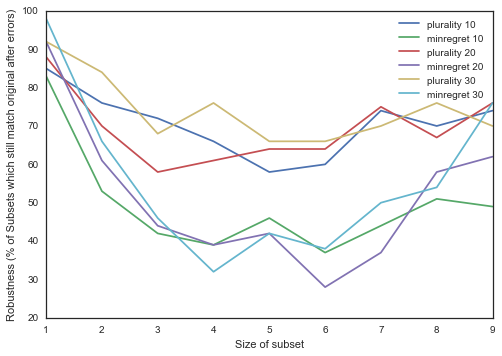

In [71]:
sns.set_style("white")
robustness_plurality = np.loadtxt('./robustness_plurality.txt')
robustness_minregret = np.loadtxt('./robustness_minregret.txt')
plt.plot(range(1,10), robustness_plurality, label='plurality 10')
plt.plot(range(1,10), robustness_minregret, label='minregret 10')
robustness_plurality = np.loadtxt('./robustness_plurality_20_voters.txt')
robustness_minregret = np.loadtxt('./robustness_minregret_20_voters.txt')
plt.plot(range(1,10), robustness_plurality, label='plurality 20')
plt.plot(range(1,10), robustness_minregret, label='minregret 20')
robustness_plurality = np.loadtxt('./robustness_plurality_30_voters.txt')
robustness_minregret = np.loadtxt('./robustness_minregret_30_voters.txt')
plt.plot(range(1,10), robustness_plurality, label='plurality 30')
plt.plot(range(1,10), robustness_minregret, label='minregret 30')
plt.ylabel('Robustness (% of Subsets which still match original after errors)')
plt.xlabel('Size of subset')
plt.legend()
plt.show()

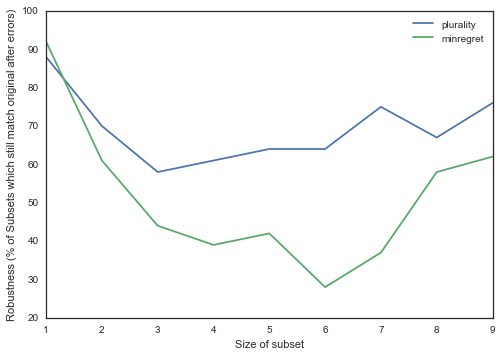

In [69]:
robustness_plurality = np.loadtxt('./robustness_plurality_20_voters.txt')
robustness_minregret = np.loadtxt('./robustness_minregret_20_voters.txt')
plt.plot(range(1,10), robustness_plurality, label='plurality')
plt.plot(range(1,10), robustness_minregret, label='minregret')
plt.ylabel('Robustness (% of Subsets which still match original after errors)')
plt.xlabel('Size of subset')
plt.legend()
plt.show()

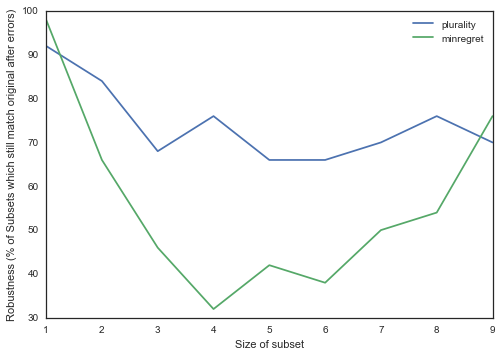

In [70]:
robustness_plurality = np.loadtxt('./robustness_plurality_30_voters.txt')
robustness_minregret = np.loadtxt('./robustness_minregret_30_voters.txt')
plt.plot(range(1,10), robustness_plurality, label='plurality')
plt.plot(range(1,10), robustness_minregret, label='minregret')
plt.ylabel('Robustness (% of Subsets which still match original after errors)')
plt.xlabel('Size of subset')
plt.legend()
plt.show()